## 7. Modele nieliniowe

In [34]:
library(yaml)
library(ggplot2)
library(splines)

# Global options
options(repr.plot.width = 10, repr.plot.height = 10)

### 7.1 Wczytywanie konfiguracji (*config.yaml*):

In [2]:
config <- yaml.load_file("../config.yaml")

train_filepath <- file.path("..", config$paths$data_train)
test_filepath <- file.path("..", config$paths$data_test)

### 7.2 Przygotowanie danych

In [3]:
data_train <- read.csv(train_filepath)

data_train$name <- NULL
data_train$games <- NULL

### 7.3 Regresja wielomianowa

**Regresja wielomianowa** to rozszerzenie regresji liniowej, w której modelujemy zależność zmiennej zależnej $y$ od jednej lub więcej potęg zmiennej niezależnej $x$. Zamiast dopasowywać prostą, dopasowujemy krzywą wielomianową.

Dla jednej zmiennej, model postaci stopnia $d$ wygląda następująco:
$$y = \beta_0 + \beta_1 x + \beta_2 x^2 + \dots + \beta_d x^d $$
gdzie:
- $\beta_0$, $\beta_1$, ..., $\beta_d$ - współczynniki modelu
- $d$ - stopień wielomianu

W poniższym przykładzie stosujemy regresję wielomianem stopnia 4, zmiennej docelowej ```elo``` względem zmiennej niezależnej ```avg_cp_loss```:

In [4]:
fit_poly <- lm(elo ~ poly(avg_cp_loss, 4), data = data_train)

summary(fit_poly)


Call:
lm(formula = elo ~ poly(avg_cp_loss, 4), data = data_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1161.36  -161.77     5.04   169.84   946.07 

Coefficients:
                        Estimate Std. Error  t value Pr(>|t|)    
(Intercept)             1592.751      2.472  644.215  < 2e-16 ***
poly(avg_cp_loss, 4)1 -29932.788    247.251 -121.062  < 2e-16 ***
poly(avg_cp_loss, 4)2   3685.230    247.251   14.905  < 2e-16 ***
poly(avg_cp_loss, 4)3   1441.446    247.251    5.830 5.72e-09 ***
poly(avg_cp_loss, 4)4  -1255.073    247.251   -5.076 3.92e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 247.3 on 9996 degrees of freedom
Multiple R-squared:  0.5991,	Adjusted R-squared:  0.5989 
F-statistic:  3734 on 4 and 9996 DF,  p-value: < 2.2e-16


Oraz z użyciem standardowej bazy wielomianów ($X$, $X^2$, $X^3$, $X^4$):

In [5]:
fit_poly_raw <- lm(elo ~ avg_cp_loss + I(avg_cp_loss^2) + I(avg_cp_loss^3) + I(avg_cp_loss^4), data = data_train)

summary(fit_poly_raw)


Call:
lm(formula = elo ~ avg_cp_loss + I(avg_cp_loss^2) + I(avg_cp_loss^3) + 
    I(avg_cp_loss^4), data = data_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1161.36  -161.77     5.04   169.84   946.07 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       2.336e+03  5.738e+01  40.720  < 2e-16 ***
avg_cp_loss       3.261e-01  2.616e+00   0.125    0.901    
I(avg_cp_loss^2) -2.396e-01  4.169e-02  -5.748 9.32e-09 ***
I(avg_cp_loss^3)  1.627e-03  2.739e-04   5.941 2.93e-09 ***
I(avg_cp_loss^4) -3.189e-06  6.281e-07  -5.076 3.92e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 247.3 on 9996 degrees of freedom
Multiple R-squared:  0.5991,	Adjusted R-squared:  0.5989 
F-statistic:  3734 on 4 and 9996 DF,  p-value: < 2.2e-16


Obie wersje modelu osiągnęły identyczne dopasowanie - mają te same wartości błędów resztowych, $R^2 (0.5991)$ i statystyki $F$. Różnią się jednak sposobem reprezentacji cech - ```fit_poly_raw używa``` surowych potęg ($x$, $x^2$, $x^3$, $x^4$), co powoduje silną współliniowość między predyktorami. To może prowadzić do niestabilnych i mniej interpretowalnych współczynników — widać to np. po tym, że liniowy składnik (avg_cp_loss) nie jest istotny statystycznie ($p = 0.901$), mimo że kolejne potęgi już tak.

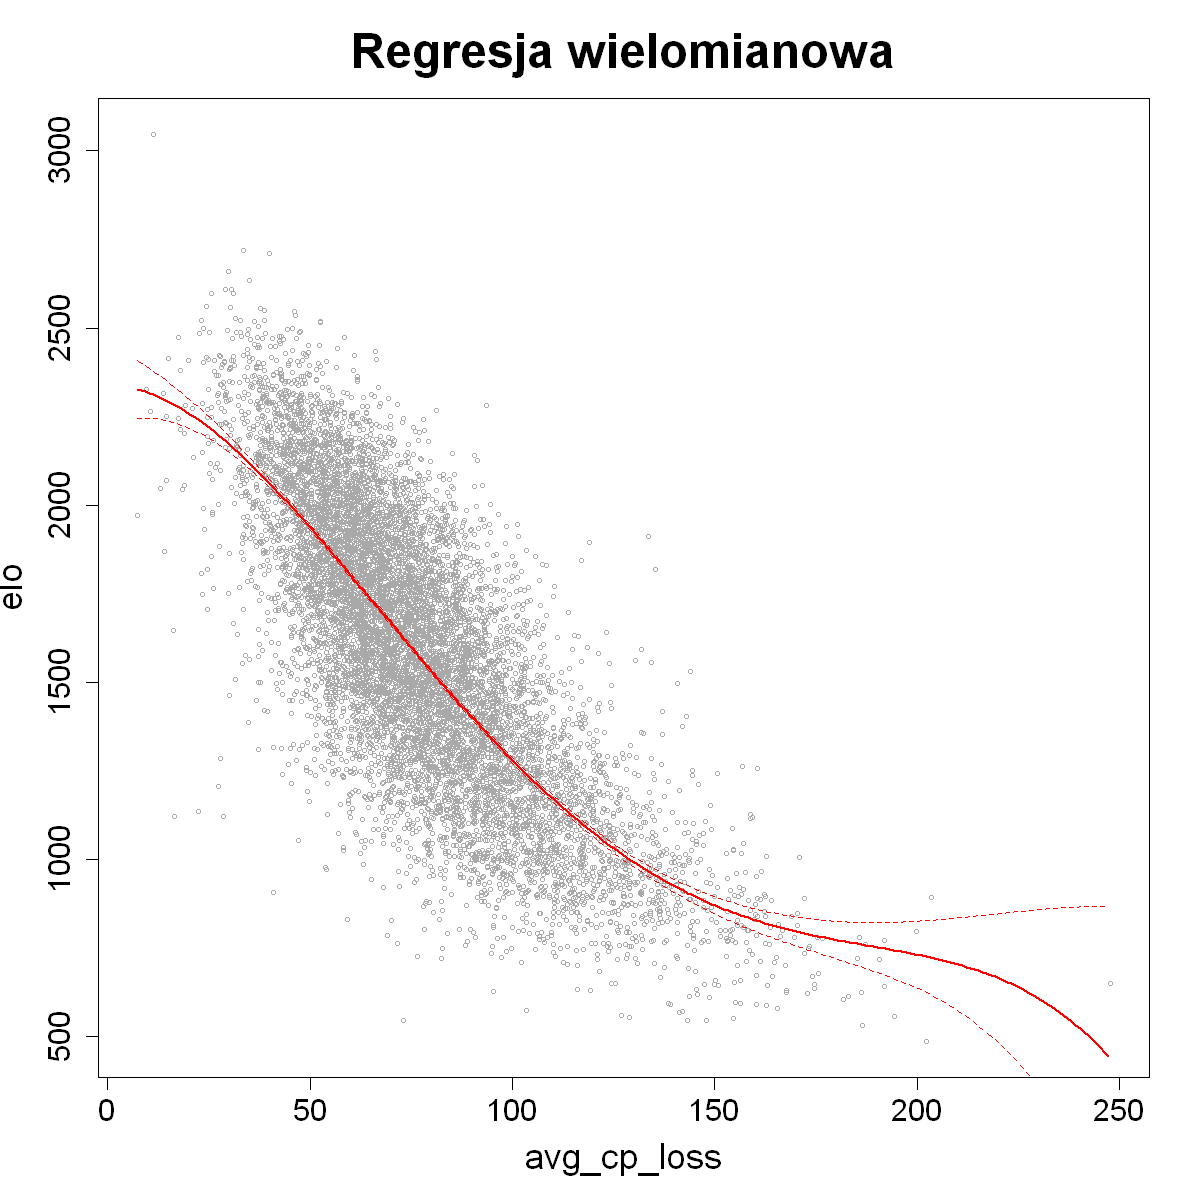

In [6]:
cp_loss_lims <- range(data_train$avg_cp_loss)
cp_loss_grid <- seq(cp_loss_lims[1], cp_loss_lims[2])

pred_poly <- predict(fit_poly, list(avg_cp_loss = cp_loss_grid), se.fit = TRUE)

se_bands <- cbind(pred_poly$fit + 2 * pred_poly$se.fit, 
                  pred_poly$fit - 2 * pred_poly$se.fit)

plot(data_train$avg_cp_loss, data_train$elo,
     col = "darkgrey", cex = 0.5, xlim = cp_loss_lims,
     cex.lab = 1.8,   # powiększa etykiety osi
     cex.axis = 1.5,  # powiększa wartości osi
     xlab = "avg_cp_loss",
     ylab = "elo")

lines(cp_loss_grid, pred_poly$fit, col = "red", lwd = 2)
matlines(cp_loss_grid, se_bands, col = "red", lty = "dashed")

title(main = "Regresja wielomianowa", cex.main = 2.4)

Jak widać jest nadal rezerwa jeśli chodzi o dopasowanie krzywej, choć może to potencjalnie wymagać użycia wielomianu wyższego stopnia lub innego typu nieliniowości.

### 7.4 Regresja logistyczna wielomianowa

**Regresja logistyczna wielomianowa** to rozszerzenie regresji logistycznej, w którym zamiast zwykłej liniowej kombinacji cech używa się kombinacji wielomianowej, np. $x, x^2, x^3$ i wyższych potęg. Dzięki temu model może uchwycić nieliniowe zależności między zmiennymi wejściowymi a prawdopodobieństwem przynależności do określonej klasy. W przeciwieństwie do zwykłej regresji wielomianowej, która przewiduje wartość liczbową i stosuje funkcję strat typu MSE, regresja wielomianowa logistyczna służy do klasyfikacji i korzysta z funkcji sigmoidalnej.

Model regresji logistycznej wielomianowej opisuje wzór:
$$P(y = 1 \mid x) = \frac{1}{1 + \exp\left( -\left( \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \cdots + \beta_d x^d \right) \right)}$$
gdzie:
- $\beta_0$, $\beta_1$, ..., $\beta_d$ - współczynniki modelu
- $d$ - stopień wielomianu

Aby wykorzystać omawiany zbiór danych do zadania klasyfikacji stosujemy identyczne podejście jak w sekcji nr 3 raportu, poświęconej regresji logistycznej - dzielimy wartości zmiennej docelowej ```elo``` na dwie grupy. Punktem podziału ponownie będzie wartość **2000 elo** rankingu - powyżej tej wartości wyróżniamy klasę pozytywną (1), a poniżej - negatywną (0).

In [7]:
fit_log_poly <- glm(I(elo >= 2000) ~ poly(avg_cp_loss, 4), data = data_train, family = binomial)

Warning message:
"glm.fit: dopasowane prawdopodobieństwa numerycznie okazały się być 0 lub 1"


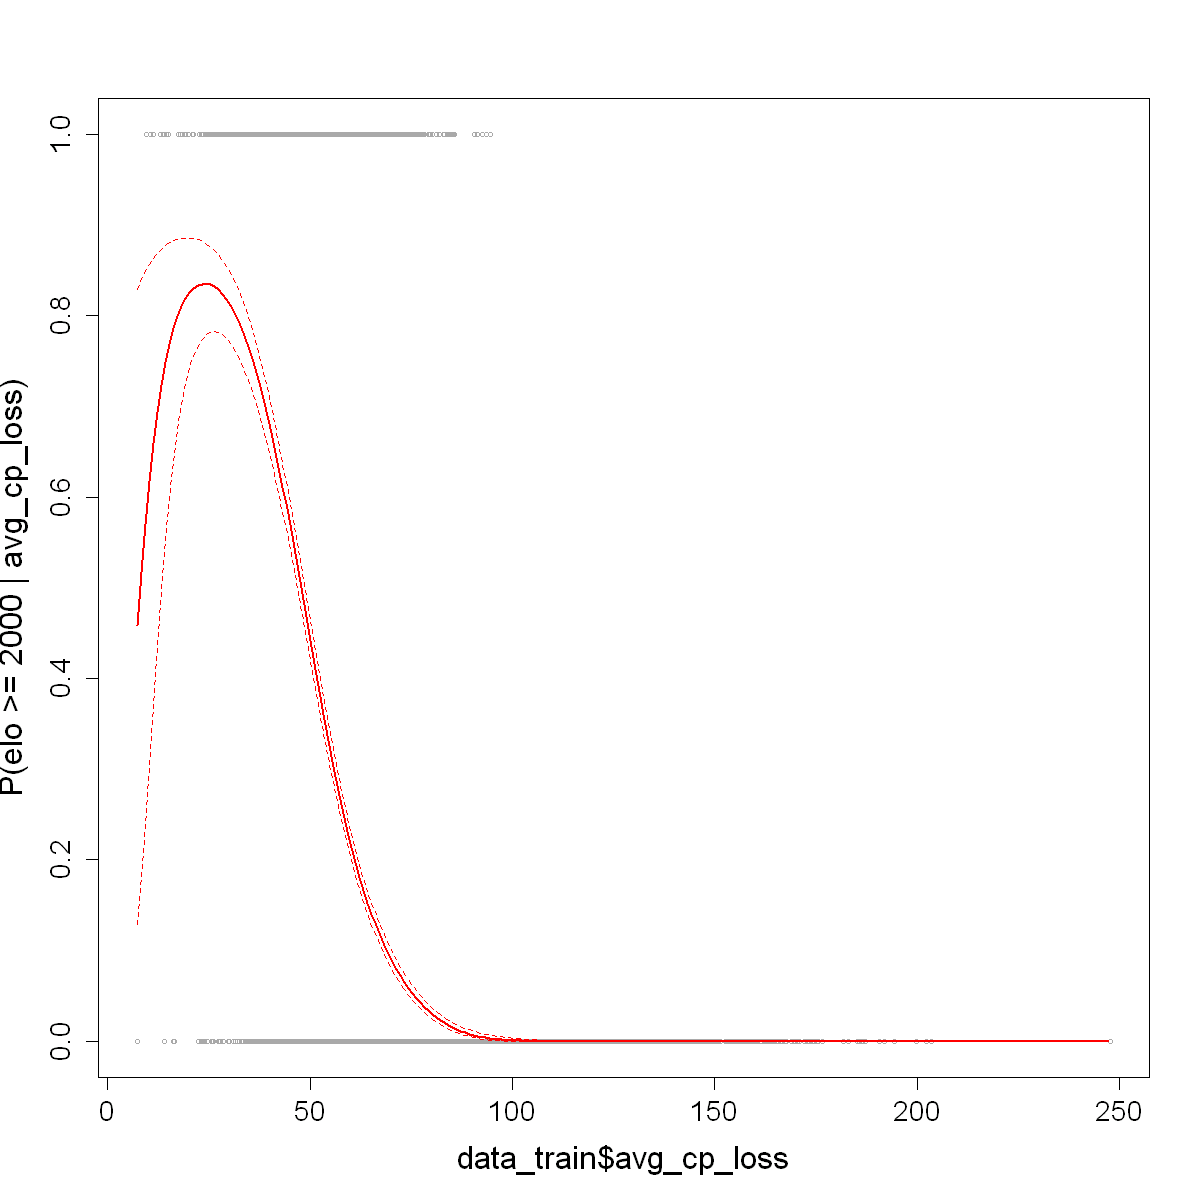

In [8]:
pred_log_poly <- predict(fit_log_poly, list(avg_cp_loss = cp_loss_grid), se.fit = TRUE)
pred_probs <- plogis(pred_log_poly$fit)

se_bands_logit <- cbind(pred_log_poly$fit + 2 * pred_log_poly$se.fit,
                        pred_log_poly$fit - 2 * pred_log_poly$se.fit)
se_bands <- plogis(se_bands_logit)

plot(data_train$avg_cp_loss, I(data_train$elo >= 2000), xlim = cp_loss_lims, ylim = c(0, 1),
     col = "darkgrey", cex = 0.5, ylab = "P(elo >= 2000 | avg_cp_loss)", 
     cex.lab = 1.6,  # powiększa napisy osi X i Y
     cex.axis = 1.4) # powiększa napisy podziałek na osiach

lines(cp_loss_grid, pred_probs, col = "red", lwd = 2)
matlines(cp_loss_grid, se_bands, lty = "dashed", col = "red")

### 7.5 Funkcje schodkowe

**Funkcje schodkowe** (ang. step functions) to funkcje, które przyjmują stałe wartości na pewnych przedziałach i zmieniają się skokowo w określonych punktach. Funkcję schodkową można zapisać jako:
$$f(x) = \sum_{i=1}^{n} c_i \cdot \mathbf{1}_{(a_{i-1},\, a_i]}(x)$$
gdzie:
- $(a_0, a_1, \ldots, a_n)$ to podział osi $x$ na przedziały,
- $c_i$ to wartość funkcji na przedziale  $(a_{i-1}, a_i]$,
- $\mathbf{1}_{(a_{i-1},\, a_i]}(x)$ to funkcja wskaźnikowa, która jest równa 1, gdy $x \in (a_{i-1}, a_i]$, a 0 w przeciwnym wypadku.

In [28]:
levels <- cut(data_train$avg_cp_loss, breaks = 4)
table(levels)

levels
(7.05,67.4]  (67.4,128]   (128,188]   (188,248] 
       3994        5584         415           8 

In [32]:
# fit_step <- lm(elo ~ cut(avg_cp_loss, 4), data = data_train)
# pred_step <- predict(fit_step, list(avg_cp_loss = cp_loss_grid), se.fit = TRUE)

# se_bands <- cbind(pred_step$fit + 2 * pred_step$se.fit, 
#                   pred_step$fit - 2 * pred_step$se.fit)

# plot(data_train$avg_cp_loss, data_train$elo, col = "darkgrey", cex = 0.5, xlim = age_lims)
# lines(cp_loss_grid, pred_step$fit, col = "red", lwd = 2)
# matlines(cp_loss_grid, se_bands, col = "red", lty = "dashed")

# Nie działa :(

### 7.6 Funkcje sklejane

**Funkcje sklejane** (ang. spline functions) to funkcje złożone z kawałków wielomianów, które są połączone (sklejone) w określonych punktach zwanych węzłami tak, aby cała funkcja była gładka i miała ciągłe pochodne do pewnego rzędu. W regresji sklejanej używa się ich do modelowania zależności nieliniowych, gdzie różne przedziały danych dopasowuje się oddzielnie, ale w sposób płynny. 

Przykładowo, funkcja sklejana stopnia 3 (spline kubiczny) może być zapisana jako:
$$ S(x) = \sum_{j=0}^{3} \beta_j x^j + \sum_{k=1}^{K} \gamma_k (x - \kappa_k)_+^3$$
gdzie $\kappa_k$ to węzły, a $(x - \kappa_k)_+^3 = \max(0,\, x - \kappa_k)^3$ jest funkcją bazową aktywną tylko dla $x > \kappa_k$.

Poniżej znajduje się przykład zastosowania regresji funkcjami sklejanymi z ustalonymi węzłami:

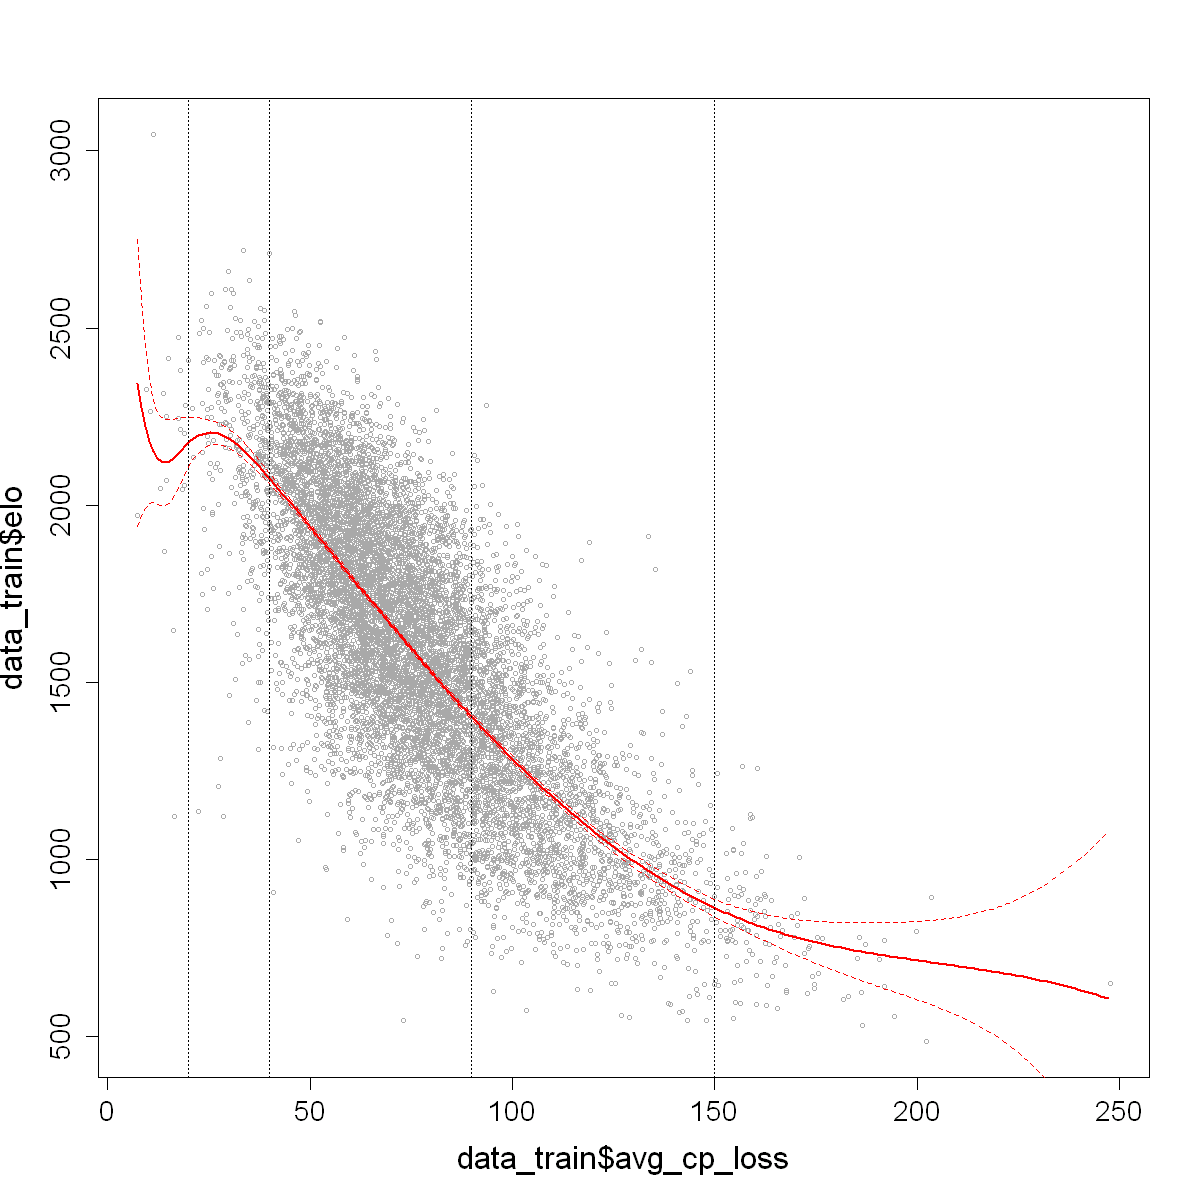

In [60]:
knots <- c(20, 40, 90, 150)

fit_bs_knots <- lm(elo ~ bs(avg_cp_loss, knots = knots), data = data_train_cut)
pred_bs_knots <- predict(fit_bs_knots, list(avg_cp_loss = cp_loss_grid), se.fit = TRUE)

plot(data_train$avg_cp_loss, data_train$elo, cex = 0.5, col = "darkgrey",
     cex.lab = 1.6,  # powiększa napisy osi X i Y
     cex.axis = 1.4) # powiększa napisy podziałek na osiach)
lines(cp_loss_grid, pred_bs_knots$fit, col = "red", lwd = 2)
lines(cp_loss_grid, pred_bs_knots$fit + 2 * pred_bs_knots$se.fit, col = "red",
      lty = "dashed")
lines(cp_loss_grid, pred_bs_knots$fit - 2 * pred_bs_knots$se.fit, col = "red",
      lty = "dashed")
abline(v = knots, lty = "dotted")

Przy punktach sklejenia ustalonych jak wyżej, funkcja sklejana dosyć dobrze dopasowuje się do danych. 

Ręczna selekcja punktów sklejenia (węzłów) może jednak prowadzić do **przeuczenia** (overfitting), jeśli wybierzemy ich zbyt wiele lub umieścimy je w miejscach odpowiadających szumowi zamiast prawdziwym zmianom w danych. Z kolei zbyt mała liczba lub niewłaściwe rozmieszczenie węzłów może powodować **niedouczenie** (underfitting) — funkcja sklejana będzie zbyt sztywna i nie odwzoruje dobrze nieliniowości w danych. Dlatego dobór węzłów jest kluczowy i często korzysta się z automatycznych metod lub reguł opartych na rozkładzie danych, by zapewnić optymalną elastyczność modelu, co zostało zaprezentowane poniżej:

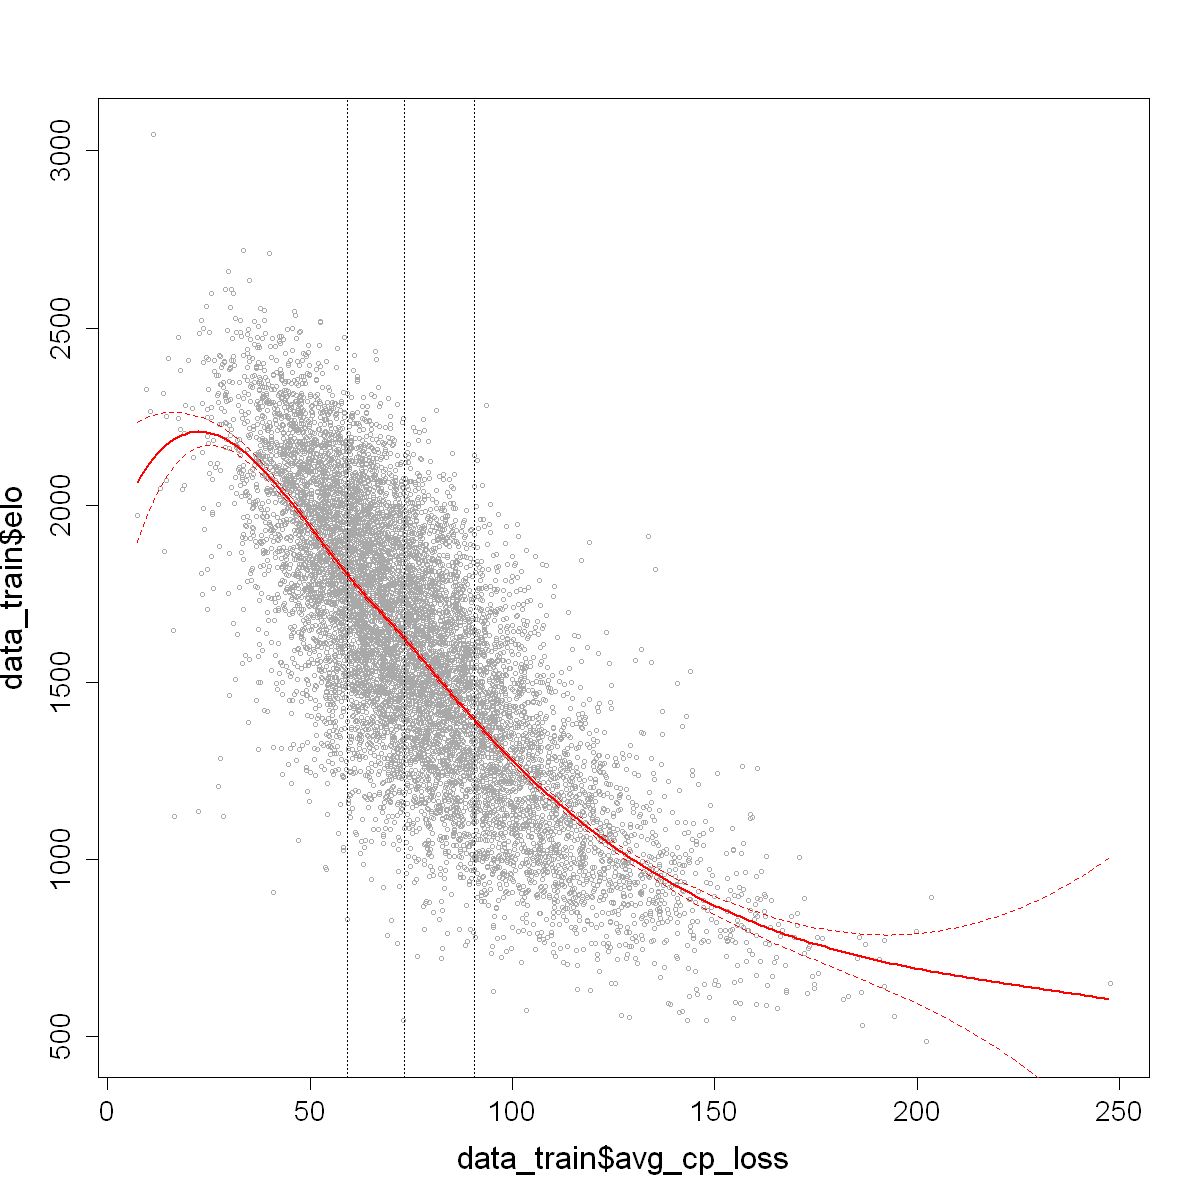

In [61]:
fit_bs_df <- lm(elo ~ bs(avg_cp_loss, df = 6), data = data_train)
pred_bs_df <- predict(fit_bs_df, list(avg_cp_loss = cp_loss_grid), se.fit = TRUE)

plot(data_train$avg_cp_loss, data_train$elo, cex = 0.5, col = "darkgrey",
     cex.lab = 1.6,  # powiększa napisy osi X i Y
     cex.axis = 1.4) # powiększa napisy podziałek na osiach)
lines(cp_loss_grid, pred_bs_df$fit, col = "red", lwd = 2)
lines(cp_loss_grid, pred_bs_df$fit + 2 * pred_bs_df$se.fit, col = "red", lty = "dashed")
lines(cp_loss_grid, pred_bs_df$fit - 2 * pred_bs_df$se.fit, col = "red", lty = "dashed")
bs_knots <- attr(bs(data_train$avg_cp_loss, df = 6), "knots")
abline(v = bs_knots, lty = "dotted")

Ciekawostką może być fakt, iż tak oto dobrana regresja funkcjami sklejanymi dla bardzo niskich wartości ```avg_cp_loss``` przyjmuje coraz niższe wartości związane z rankingiem gracza. Sugeruje to wpływ wartości odstających (outliers) na wyniki regresji. Sytuacje, w której gracze o stosunkowo niskim rankingu grają na bardzo wysokiej precyzji mogą świadczyć o potencjalnym oszukiwaniu i grze wspomaganej przez komputer.

### 7.7 Naturalne funkcje sklejane

**Naturalne funkcje sklejane** (ang. natural splines) to szczególny rodzaj funkcji sklejanek, zwykle kubicznych, które poza zakresem węzłów (czyli poza najbardziej skrajnymi punktami sklejenia) zachowują się jak funkcja liniowa. Oznacza to, że końce funkcji (tzw. ogony) nie wyginają się nieliniowo, co zwiększa stabilność modelu na brzegach danych.

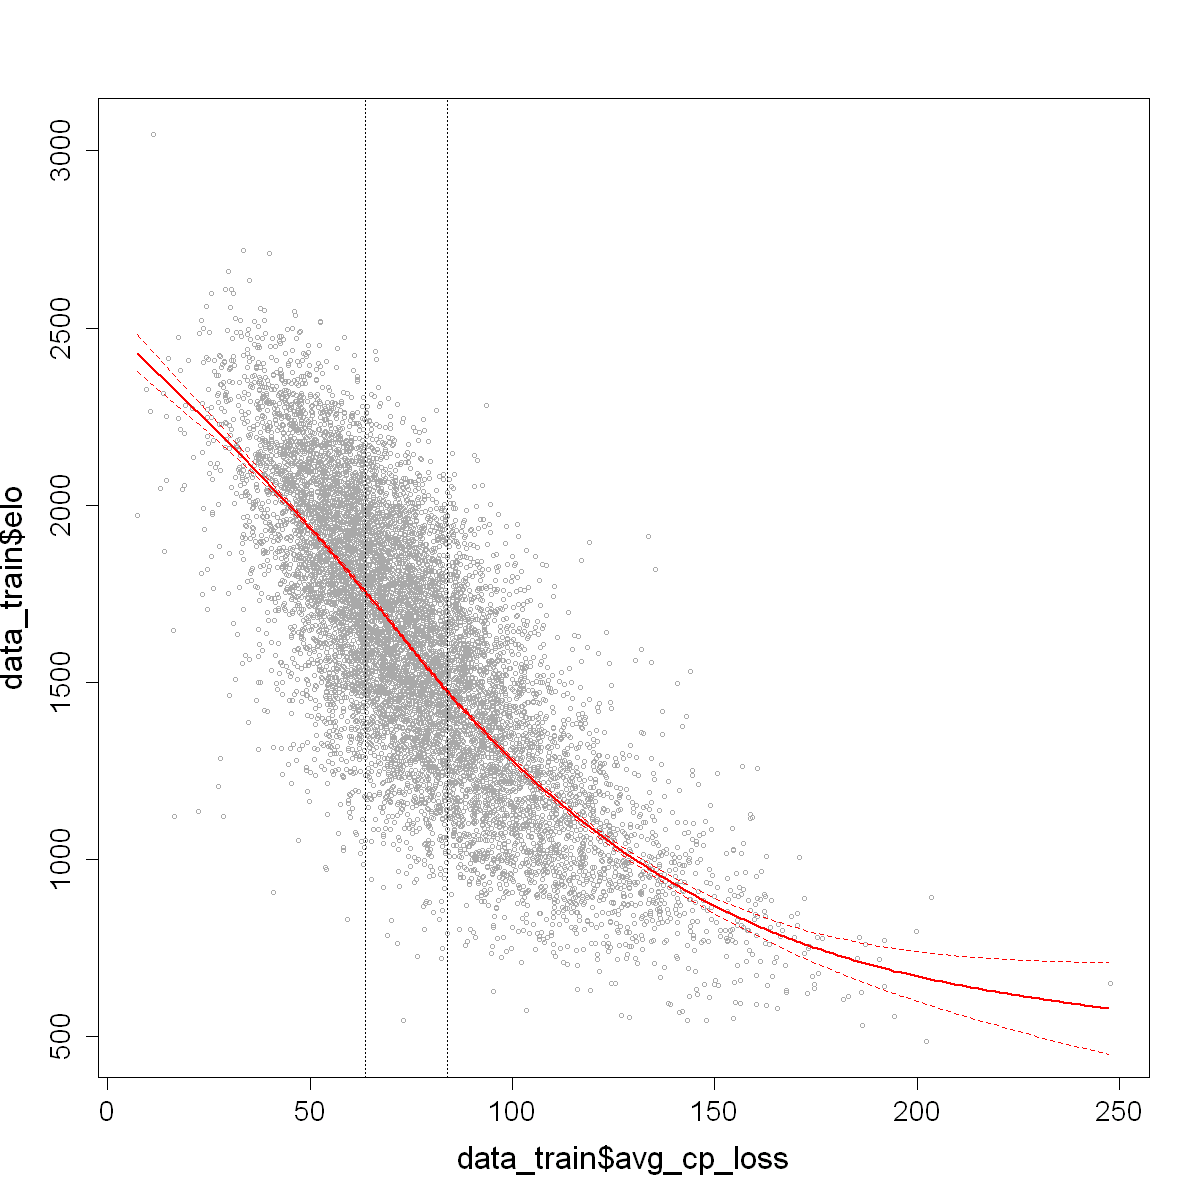

In [66]:
df = 3

fit_ns <- lm(elo ~ ns(avg_cp_loss, df = df), data = data_train)
pred_ns <- predict(fit_ns, list(avg_cp_loss = cp_loss_grid), se.fit = TRUE)

plot(data_train$avg_cp_loss, data_train$elo, cex = 0.5, col = "darkgrey",
     cex.lab = 1.6,  # powiększa napisy osi X i Y
     cex.axis = 1.4) # powiększa napisy podziałek na osiach)
lines(cp_loss_grid, pred_ns$fit, col = "red", lwd = 2)
lines(cp_loss_grid, pred_ns$fit + 2 * pred_ns$se.fit, col = "red",
      lty = "dashed")
lines(cp_loss_grid, pred_ns$fit - 2 * pred_ns$se.fit, col = "red",
      lty = "dashed")
abline(v = attr(ns(data_train$avg_cp_loss, df = df), "knots"), lty = "dotted")

Naturalne funkcje sklejane osiągnęły zdaje się najlepsze dopasowanie ze wszystkich prezentowanych w tej sekcji metod. Warto jednak zaznaczyć, iż kluczowe jest dobranie odpowiedniej liczby stopni swobody - zbyt mała liczba stopni swobody prowadzi do niedouczenia (ang. underfitting), gdy model jest zbyt prosty i nie potrafi uchwycić rzeczywistej nieliniowości w danych. Z kolei zbyt duża liczba ```df``` skutkuje przeuczeniem (ang. overfitting), gdy funkcja staje się zbyt elastyczna i dopasowuje się również do przypadkowego szumu, co obniża jej zdolność do generalizacji na nowe dane. W praktyce df kontroluje liczbę parametrów opisujących kształt funkcji – im więcej stopni swobody, tym więcej punktów, w których funkcja może zmieniać kierunek.

Poniżej przedstawiono przykład z wykorzystaniem dużej liczby stopni swobody:

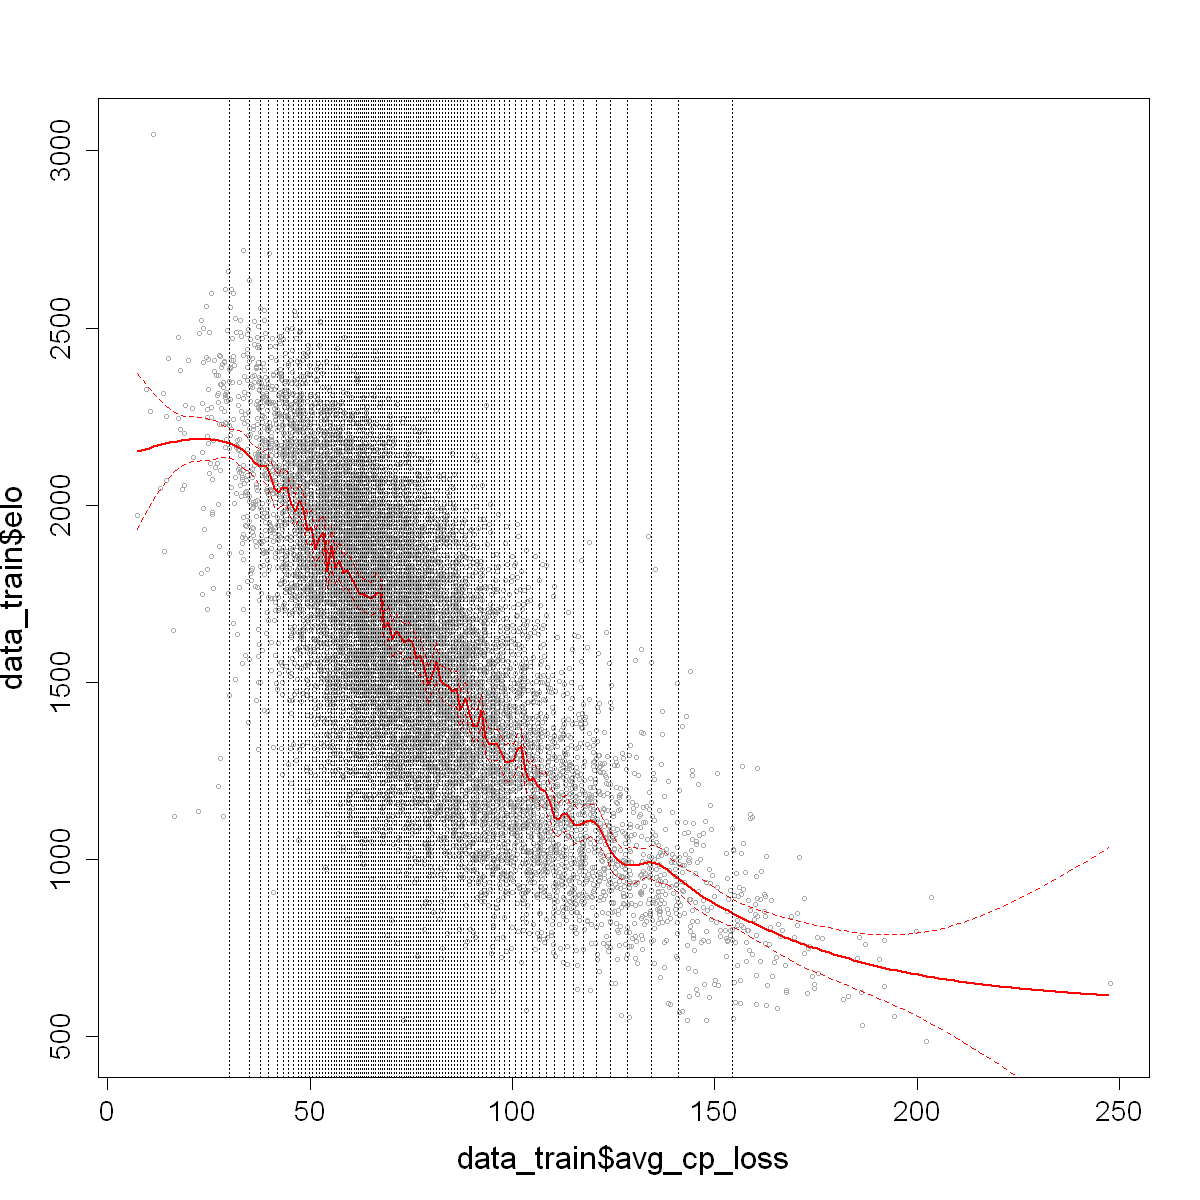

In [67]:
df = 100

fit_ns <- lm(elo ~ ns(avg_cp_loss, df = df), data = data_train)
pred_ns <- predict(fit_ns, list(avg_cp_loss = cp_loss_grid), se.fit = TRUE)

plot(data_train$avg_cp_loss, data_train$elo, cex = 0.5, col = "darkgrey",
     cex.lab = 1.6,  # powiększa napisy osi X i Y
     cex.axis = 1.4) # powiększa napisy podziałek na osiach)
lines(cp_loss_grid, pred_ns$fit, col = "red", lwd = 2)
lines(cp_loss_grid, pred_ns$fit + 2 * pred_ns$se.fit, col = "red",
      lty = "dashed")
lines(cp_loss_grid, pred_ns$fit - 2 * pred_ns$se.fit, col = "red",
      lty = "dashed")
abline(v = attr(ns(data_train$avg_cp_loss, df = df), "knots"), lty = "dotted")

Widzimy bardzo dużo lokalnych skoków - model próbuje zbyt dobrze dopasować się do danych uczących.

### 7.8 Wygładzające funkcje sklejane

**Wygładzające funkcje sklejane** (ang. smoothing splines) to narzędzie regresji nieliniowej, które automatycznie dopasowuje gładką funkcję do danych, równoważąc precyzyjne dopasowanie punktów obserwacyjnych z gładkością krzywej. W przeciwieństwie do klasycznych splajnów, liczba i położenie węzłów nie są ustalane ręcznie — zamiast tego wprowadza się parametr wygładzania (najczęściej oznaczany $\lambda$), który kontroluje kompromis między dokładnością dopasowania a płynnością funkcji. Dla $\lambda = 0$ funkcja przechodzi dokładnie przez wszystkie punkty (interpolacja), a dla dużych $\lambda$ zbliża się do funkcji liniowej.

W poniższym przykładzie wyznaczamy wprost liczbę stopni swobody dla wygładzających funkcji sklejanych korzystając z walidacji krzyżowej:

Warning message in smooth.spline(data_train$avg_cp_loss, data_train$elo, cv = TRUE):
"krzyżowa walidacja z nieunikalnymi wartościami 'x' wydaje się wątpliwa"


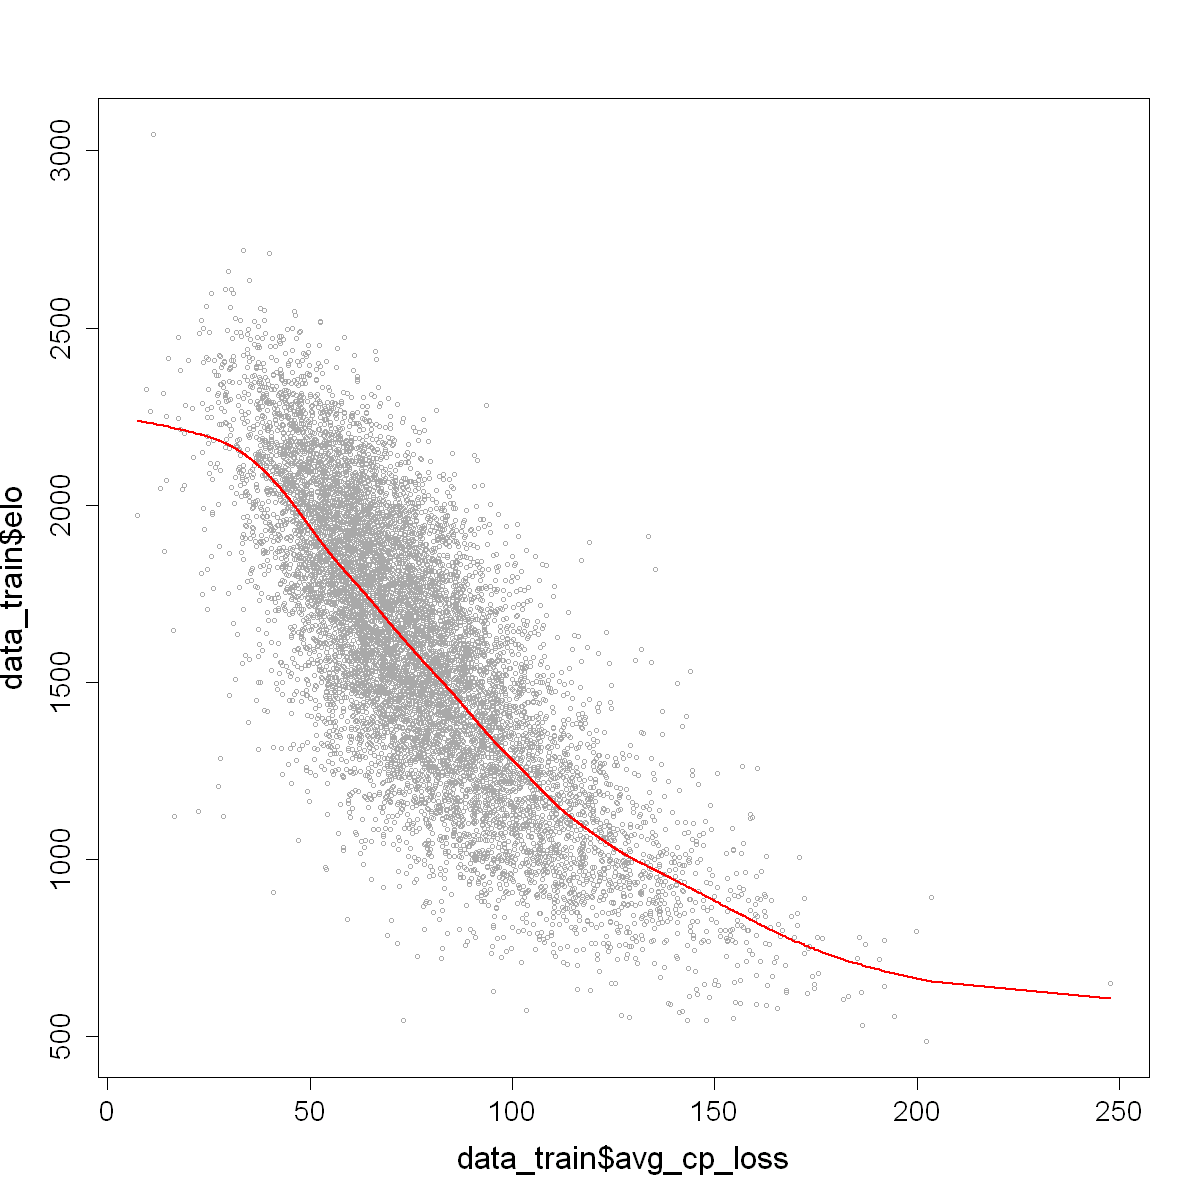

In [70]:
fit_smooth_cv <- smooth.spline(data_train$avg_cp_loss, data_train$elo, cv = TRUE)

plot(data_train$avg_cp_loss, data_train$elo, cex = 0.5, col = "darkgrey",
     cex.lab = 1.6,  # powiększa napisy osi X i Y
     cex.axis = 1.4) # powiększa napisy podziałek na osiach)
lines(fit_smooth_cv, col = "red", lwd = 2)